/home/r/.local/lib/python3.8/site-packages/matplotlib/animation.py:973: UserWarning: Animation was deleted without rendering anything. This is most likely unintended. To prevent deletion, assign the Animation to a variable that exists for as long as you need the Animation.
  warnings.warn(


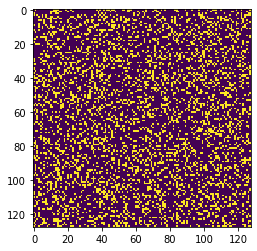

In [107]:
# Conway's game of life in Python / CUDA C
# written by Brian Tuomanen for "Hands on GPU Programming with Python and CUDA"

import pycuda.autoinit
import pycuda.driver as drv
from pycuda import gpuarray
from pycuda.compiler import SourceModule
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.animation as animation
import tkinter

ker = SourceModule("""
#define _X  ( threadIdx.x + blockIdx.x * blockDim.x )
#define _Y  ( threadIdx.y + blockIdx.y * blockDim.y )

#define _WIDTH  ( blockDim.x * gridDim.x )
#define _HEIGHT ( blockDim.y * gridDim.y  )

/*When we calculate the number of living neighbors of a given cell, we might be at some edge and the
neighbors might be external points—defining these macros to modulate our points will cover this for us
automatically.*/ 
#define _XM(x)  ( (x + _WIDTH) % _WIDTH )
#define _YM(y)  ( (y + _HEIGHT) % _HEIGHT )


// porque Python pasa como vector, no como matriz
#define _INDEX(x,y)  ( _XM(x)  + _YM(y) * _WIDTH )

// return the number of living neighbors for a given cell                
// Device functions cannot by themselves by launched by a host computer onto a GPU, only kernels
__device__ int nbrs(int x, int y, int * in)
{
    //in is the input lattice
     return ( in[ _INDEX(x -1, y+1) ] + in[ _INDEX(x-1, y) ] + in[ _INDEX(x-1, y-1) ] \
                   + in[ _INDEX(x, y+1)] + in[_INDEX(x, y - 1)] \
                   + in[ _INDEX(x+1, y+1) ] + in[ _INDEX(x+1, y) ] + in[ _INDEX(x+1, y-1) ] );
}

__global__ void conway_ker(int * lattice_out, int * lattice  )
{
   // x, y are the appropriate values for the cell covered by this thread
   int x = _X, y = _Y;
   
   // count the number of neighbors around the current cell
   int n = nbrs(x, y, lattice);
                   
    
    // if the current cell is alive, then determine if it lives or dies for the next generation.
    if ( lattice[_INDEX(x,y)] == 1)
       switch(n)
       {
           // 1 will represent a living cell and 0 will represent a dead one
          // if the cell is alive: it remains alive only if it has 2 or 3 neighbors
          
          case 2:
          case 3: lattice_out[_INDEX(x,y)] = 1;
                  break;
          default: lattice_out[_INDEX(x,y)] = 0;                   
       }
    else if( lattice[_INDEX(x,y)] == 0 )
         switch(n)
         {
            // a dead cell comes to life only if it has 3 neighbors that are alive.
            case 3: lattice_out[_INDEX(x,y)] = 1;
                    break;
            default: lattice_out[_INDEX(x,y)] = 0;         
         }
         
}
""")


conway_ker = ker.get_function("conway_ker")
     

def update_gpu(frameNum, img, newLattice_gpu, lattice_gpu, N):
    #128 /32 = 4
    conway_ker(  newLattice_gpu, lattice_gpu, grid=(4,4,1), block=(32,32,1)   )
    
    img.set_data(newLattice_gpu.get() )
    
    
    lattice_gpu[:] = newLattice_gpu[:]
    
    return img
    

if __name__ == '__main__':
    # set lattice size
    N = 128
    #around 25% of the points are ones and the rest zeros
    lattice = np.int32( np.random.choice([1,0], N*N, p=[0.25, 0.75]).reshape(N, N) )
    lattice_gpu = gpuarray.to_gpu(lattice)
    
    newLattice_gpu = gpuarray.empty_like(lattice_gpu)        

    fig, ax = plt.subplots()
    img = ax.imshow(lattice_gpu.get(), interpolation='nearest')
    ani = animation.FuncAnimation(fig, update_gpu, fargs=(img, newLattice_gpu, lattice_gpu, N, ) , interval=1000, frames=10, save_count=1000)    
     
    plt.show()
